In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def preprocess(data):
    #print(data['Unnamed: 15'].value_counts())
    #print(data['Unnamed: 16'].value_counts())
    data = data.drop(columns=['Unnamed: 15', 'Unnamed: 16'])
    
    
    data['DateTime'] = data['Time'] + '/' + data['Date']
    data['DateTime'] = pd.to_datetime(data['DateTime'], format='%H.%M.%S/%d/%m/%Y')
    
    data = data.drop(columns=['Time', 'Date'])
    data['HourOfDay'] = data['DateTime'].dt.hour
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    data['Month'] = data['DateTime'].dt.month
    #data['Year'] = data['DateTime'].dt.year
    convert_feature_into_cyclic(data, 'HourOfDay', 24)
    convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    convert_feature_into_cyclic(data, 'Month', 12)
    #convert_feature_into_cyclic(data, 'Year', 2)
    data.drop(columns=['HourOfDay', 'DayOfWeek', 'Month','NMHC(GT)'], inplace=True)

    # use fill forward imputation for 0 values

    data = data.replace(',', '.', regex=True)


    data['PT08.S1(CO)'] = data['PT08.S1(CO)'].mask(data['PT08.S1(CO)'] < 0, np.nan)
    
    
    
    data['PT08.S2(NMHC)'] = data['PT08.S2(NMHC)'].mask(data['PT08.S2(NMHC)'] < 0, np.nan)
    data['NOx(GT)'] = data['NOx(GT)'].mask(data['NOx(GT)'] < 0, np.nan)
    data['NO2(GT)'] = data['NO2(GT)'].mask(data['NO2(GT)'] < 0, np.nan)
    data['PT08.S4(NO2)'] = data['PT08.S4(NO2)'].mask(data['PT08.S4(NO2)'] < 0, np.nan)
    data['PT08.S5(O3)'] = data['PT08.S5(O3)'].mask(data['PT08.S5(O3)'] < 0, np.nan)
    data = data.ffill()

    # columns with missing values
    #print(data.isna().sum())
    # drop because of high correlation
    data = data.drop(columns=['PT08.S1(CO)','C6H6(GT)', 'PT08.S2(NMHC)'])

    data = data[data['PT08.S3(NOx)'] > 0]
    dates = data['DateTime']
    data = data.drop(columns=['DateTime'])

    data = data.dropna()
    
    return data, dates

# Read in the data

data = pd.read_csv('../csvs/AirQualityUCI.csv', sep=';')
data.head(n=100)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,14/03/2004,17.00.00,"2,9",1438.0,156.0,"12,0",1051.0,180.0,943.0,128.0,1668.0,1206.0,"21,3","30,8","0,7696",NaN,NaN
96,14/03/2004,18.00.00,"2,5",1478.0,122.0,"12,2",1055.0,160.0,929.0,121.0,1671.0,1262.0,"19,7","36,7","0,8307",NaN,NaN
97,14/03/2004,19.00.00,"4,6",1808.0,262.0,"20,6",1312.0,261.0,753.0,157.0,1993.0,1698.0,"18,4","41,7","0,8732",NaN,NaN
98,14/03/2004,20.00.00,"5,9",1898.0,341.0,"23,1",1381.0,325.0,681.0,173.0,2103.0,1905.0,"17,6","46,1","0,9210",NaN,NaN


In [2]:
'''from util import plot_feature_over_time

plot_feature_over_time(data, feature='CO(GT)', dates = dates, shape=(20,7))
#plot_feature_over_time(data, feature='PT08.S1(CO)', dates = dates, shape=(20,7))
#plot_feature_over_time(data, feature='NMHC(GT)', dates = dates, shape=(20,7))
#plot_feature_over_time(data, feature='C6H6(GT)', dates = dates, shape=(20,7))
#plot_feature_over_time(data, feature='PT08.S2(NMHC)', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='NOx(GT)', dates = dates, shape=(20,7))
# target feature
plot_feature_over_time(data, feature='PT08.S3(NOx)', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='NO2(GT)', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='PT08.S4(NO2)', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='PT08.S5(O3)', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='T', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='RH', dates = dates, shape=(20,7))
plot_feature_over_time(data, feature='AH', dates = dates, shape=(20,7))'''

"from util import plot_feature_over_time\n\nplot_feature_over_time(data, feature='CO(GT)', dates = dates, shape=(20,7))\n#plot_feature_over_time(data, feature='PT08.S1(CO)', dates = dates, shape=(20,7))\n#plot_feature_over_time(data, feature='NMHC(GT)', dates = dates, shape=(20,7))\n#plot_feature_over_time(data, feature='C6H6(GT)', dates = dates, shape=(20,7))\n#plot_feature_over_time(data, feature='PT08.S2(NMHC)', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='NOx(GT)', dates = dates, shape=(20,7))\n# target feature\nplot_feature_over_time(data, feature='PT08.S3(NOx)', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='NO2(GT)', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='PT08.S4(NO2)', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='PT08.S5(O3)', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='T', dates = dates, shape=(20,7))\nplot_feature_over_time(data, feature='RH', dates = dates,

In [3]:
'''corr = data.corr()
corr[abs(corr) > 0.8]'''

'corr = data.corr()\ncorr[abs(corr) > 0.8]'

In [3]:
split_index = int(len(data) * 0.7)
train = data[:split_index]
train, _ = preprocess(train)
test = data[split_index:]

In [ ]:
import pickle

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 777879.8221, Validation Loss: 660273.1481
Epoch [2/100], Loss: 693531.2393, Validation Loss: 586439.0480
Epoch [3/100], Loss: 613846.4522, Validation Loss: 519953.0961
Epoch [4/100], Loss: 542109.9794, Validation Loss: 460425.8230
Epoch [5/100], Loss: 477307.6517, Validation Loss: 407214.0993
Epoch [6/100], Loss: 419935.2659, Validation Loss: 359893.3093
Epoch [7/100], Loss: 366908.5857, Validation Loss: 317881.9225
Epoch [8/100], Loss: 319869.0885, Validation Loss: 280915.5713
Epoch [9/100], Loss: 278285.1134, Validation Loss: 248577.8509
Epoch [10/100], Loss: 241174.0090, Validation Loss: 220573.0667
Epoch [11/100], Loss: 207598.7178, Validation Loss: 196658.9127
Epoch [12/100], Loss: 179765.4567, Validation Loss: 176536.1289
Epoch [13/100], Loss: 155854.3241, Validation Loss: 159867.9325
Epoch [14/100], Loss: 135084.7294, Validation Loss: 146401.2471
E

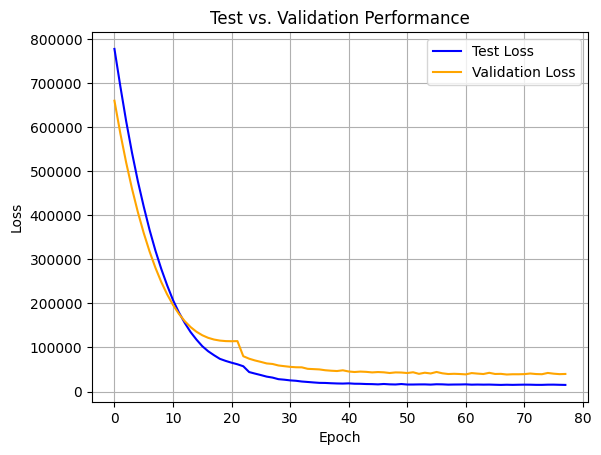

In [8]:
results_elman_h32 = training(data=train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 780036.9327, Validation Loss: 662316.5704
Epoch [2/100], Loss: 702292.3897, Validation Loss: 591701.3002
Epoch [3/100], Loss: 623766.3827, Validation Loss: 526404.1976
Epoch [4/100], Loss: 550185.6789, Validation Loss: 467082.9593
Epoch [5/100], Loss: 485453.0105, Validation Loss: 414116.9722
Epoch [6/100], Loss: 426611.2910, Validation Loss: 366861.9619
Epoch [7/100], Loss: 375123.9785, Validation Loss: 324982.9853
Epoch [8/100], Loss: 328212.0410, Validation Loss: 287991.4451
Epoch [9/100], Loss: 286203.3791, Validation Loss: 255520.9083
Epoch [10/100], Loss: 250049.9869, Validation Loss: 227236.0846
Epoch [11/100], Loss: 216560.7799, Validation Loss: 202889.7565
Epoch [12/100], Loss: 188511.6399, Validation Loss: 182182.7575
Epoch [13/100], Loss: 163008.6788, Validation Loss: 164868.3771
Epoch [14/100], Loss: 140640.6949, Validation Loss: 150692.4459
E

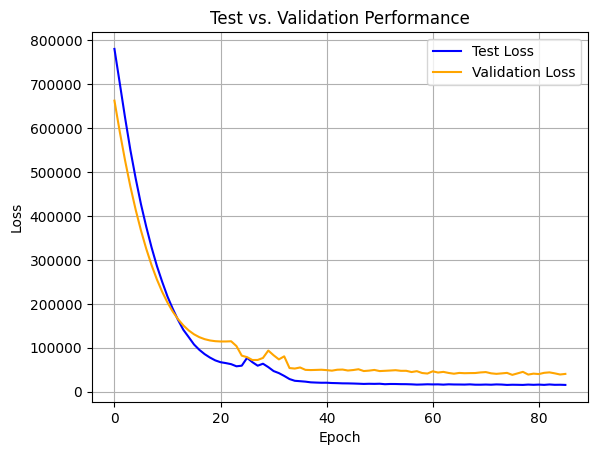

In [9]:
results_jordan_h32 = training(data=train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=train.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



In [11]:
import pickle
pickle.dump(results_elman_h32, open('../pickles/airquality_results_elman_h32.pkl', 'wb'))
pickle.dump(results_jordan_h32, open('../pickles/airquality_results_jordan_h32.pkl', 'wb'))

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 753152.5495, Validation Loss: 604804.9525
Epoch [2/100], Loss: 614564.8440, Validation Loss: 482556.9814
Epoch [3/100], Loss: 484256.6081, Validation Loss: 381766.6912
Epoch [4/100], Loss: 379749.1480, Validation Loss: 302473.6420
Epoch [5/100], Loss: 295802.7500, Validation Loss: 241519.7001
Epoch [6/100], Loss: 229178.0433, Validation Loss: 195942.4617
Epoch [7/100], Loss: 176578.1023, Validation Loss: 163158.9761
Epoch [8/100], Loss: 134470.3753, Validation Loss: 139732.0099
Epoch [9/100], Loss: 107838.2592, Validation Loss: 124391.7538
Epoch [10/100], Loss: 88361.9241, Validation Loss: 114815.4378
Epoch [11/100], Loss: 71712.2646, Validation Loss: 102113.4436
Epoch [12/100], Loss: 66125.4587, Validation Loss: 90095.7715
Epoch [13/100], Loss: 53054.9650, Validation Loss: 80049.3535
Epoch [14/100], Loss: 42567.8714, Validation Loss: 73063.1131
Epoch [15

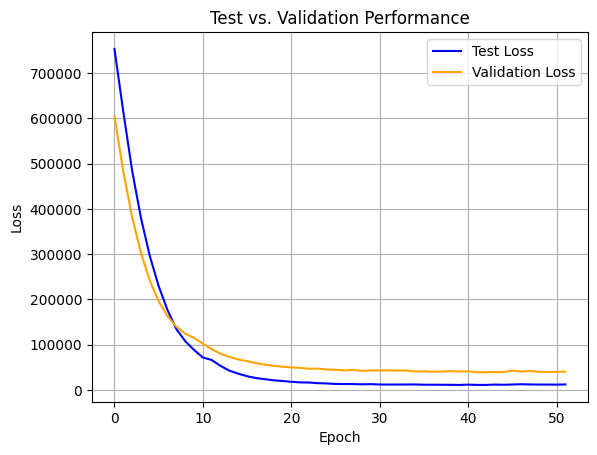

In [12]:
results_elman_h64 = training(data=train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=train.shape[1]-1, hidden_size=64, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 629303.0947, Validation Loss: 363653.5178
Epoch [2/100], Loss: 220324.5394, Validation Loss: 137239.1770
Epoch [3/100], Loss: 78439.9042, Validation Loss: 111499.6650
Epoch [4/100], Loss: 55558.3649, Validation Loss: 110693.0078
Epoch [5/100], Loss: 48720.9238, Validation Loss: 101057.1836
Epoch [6/100], Loss: 41689.6302, Validation Loss: 81723.7508
Epoch [7/100], Loss: 33224.5688, Validation Loss: 70420.2438
Epoch [8/100], Loss: 25210.4134, Validation Loss: 60303.7679
Epoch [9/100], Loss: 22815.9083, Validation Loss: 57758.5430
Epoch [10/100], Loss: 19777.5996, Validation Loss: 54936.9853
Epoch [11/100], Loss: 20390.8691, Validation Loss: 51942.2600
Epoch [12/100], Loss: 19460.5700, Validation Loss: 50616.6768
Epoch [13/100], Loss: 18216.9690, Validation Loss: 49237.6839
Epoch [14/100], Loss: 17206.0354, Validation Loss: 47688.3758
Epoch [15/100], Loss: 

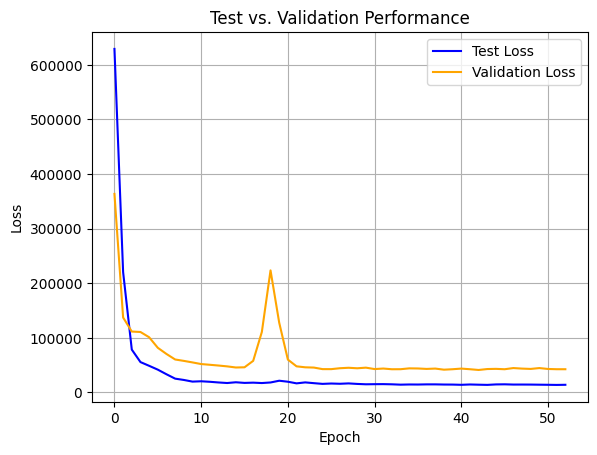

In [17]:
results_jordan_h64 = training(data=train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=train.shape[1]-1, hidden_size=64, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.05,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



In [18]:
import pickle
pickle.dump(results_elman_h64, open('../pickles/airquality_results_elman_h64.pkl', 'wb'))
pickle.dump(results_jordan_h64, open('../pickles/airquality_results_jordan_h64.pkl', 'wb'))

In [14]:
'''results_recurr = training(data=train,
         target_feature_name='PT08.S3(NOx)',
         model=MultiRecurrentNN(input_size=train.shape[1]-1, hidden_size=32, output_size=1, memory_config=[4,4,4], dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.05,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)'''

"results_recurr = training(data=train,\n         target_feature_name='PT08.S3(NOx)',\n         model=MultiRecurrentNN(input_size=train.shape[1]-1, hidden_size=32, output_size=1, memory_config=[4,4,4], dropout=0.2),\n         num_epochs=100,\n         # Reduced because of noise\n         splits=4,\n         patience=10,\n         scaler_X=RobustScaler(),\n         optimizer_learning_rate=0.05,\n         optimizer_weight_decay=1e-5,\n         optimizer_b1=0.6,\n         optimizer_b2=0.999,\n         use_final_fold=True)"

In [ ]:
'''import torch
#preds = results['model'](torch.tensor(test.drop(columns=['PT08.S3(NOx)']).values, dtype=torch.float32))
scaler = results_recurr['scaler_X']
model = results_recurr['model']
test_scaled, test_dates = preprocess(test)
print(test_dates.shape)
test_scaled = scaler.transform(test_scaled.drop(columns=['PT08.S3(NOx)']))
test_scaled = torch.tensor(test_scaled, dtype=torch.float32).unsqueeze(1)
preds = model(test_scaled)
preds = preds.detach().numpy()
preds = preds.squeeze()
print(preds.shape)
actual = test['PT08.S3(NOx)'].values
actual = actual[-len(preds):]
print(actual.shape)

# plot
plt.figure(figsize=(15,7))
plt.plot(test_dates, actual, label='Actual')
plt.plot(test_dates, preds, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PT08.S3(NOx)')
plt.title('Actual vs Predicted PT08.S3(NOx) on Test Set')
plt.legend()
plt.show()'''

"import torch\n#preds = results['model'](torch.tensor(test.drop(columns=['PT08.S3(NOx)']).values, dtype=torch.float32))\nscaler = results_recurr['scaler_X']\nmodel = results_recurr['model']\ntest_scaled, test_dates = preprocess(test)\nprint(test_dates.shape)\ntest_scaled = scaler.transform(test_scaled.drop(columns=['PT08.S3(NOx)']))\ntest_scaled = torch.tensor(test_scaled, dtype=torch.float32).unsqueeze(1)\npreds = model(test_scaled)\npreds = preds.detach().numpy()\npreds = preds.squeeze()\nprint(preds.shape)\nactual = test['PT08.S3(NOx)'].values\nactual = actual[-len(preds):]\nprint(actual.shape)\n\n# plot\nplt.figure(figsize=(15,7))\nplt.plot(test_dates, actual, label='Actual')\nplt.plot(test_dates, preds, label='Predicted')\nplt.xlabel('Date')\nplt.ylabel('PT08.S3(NOx)')\nplt.title('Actual vs Predicted PT08.S3(NOx) on Test Set')\nplt.legend()\nplt.show()"